In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

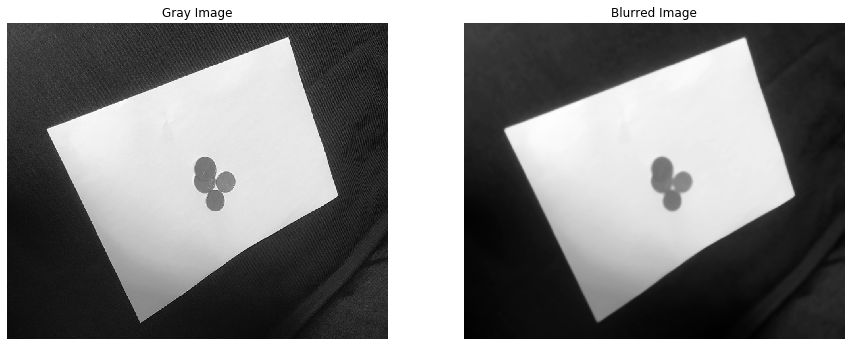

In [2]:
# Grayscale로 변환
img = cv2.imread('./images/second.jpg')
img_ori = img.copy()
img_gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)


# Blurring
# cv2.medianBlur(src, ksize[, dst]) -> dst
dst = cv2.bilateralFilter(img_gray, 10, 100, 100) # Bilateral Filtering
dst1 = cv2.GaussianBlur(dst, (5,5), 0)            # GaussianBlur
dst2 = cv2.medianBlur(dst1, 9)                    # Median Blur


plt.figure(figsize=(15,15))
plt.subplot(121), plt.imshow(img_gray, cmap='gray'), plt.title('Gray Image'), plt.axis('off')
plt.subplot(122), plt.imshow(dst2, cmap='gray'), plt.title('Blurred Image'), plt.axis('off')
plt.show()

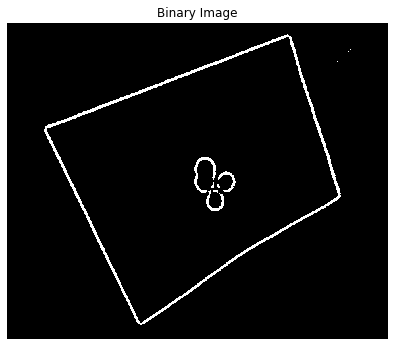

In [3]:
# (1) Adaptive Thresholding
# cv2.adaptiveThreshold(src, maxValue, adaptiveMethod, thresholdType, blockSize, C[, dst]) -> dst
binary_img = cv2.adaptiveThreshold(dst, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 21, 5)
binary_img = cv2.bitwise_not(binary_img)

'''
# (2) Thresholding
# cv2.threshold(src, thresh, maxval, type[, dst]) -> retval, dst
ret_threshold, binary_img = cv2.threshold(dst2, 170, 255, cv2.THRESH_BINARY_INV)
binary_img = cv2.bitwise_not(binary_img)
'''

plt.figure(figsize=(15,15))
plt.subplot(121), plt.imshow(binary_img, cmap='gray'), plt.title('Binary Image'), plt.axis('off')
plt.show()

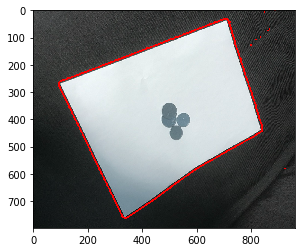

In [4]:
#contour을 찾고 A4용지의 외곽선 그리기
# cv2.findContours(image, mode, method[, contours[, hierarchy[, offset]]]) -> image, contours, hierarchy
img, contour, hierarchy = cv2.findContours(binary_img, 
                                            cv2.RETR_EXTERNAL, 
                                            cv2.CHAIN_APPROX_SIMPLE)
img = img_ori.copy()


# Draw Contour
cv2.drawContours(img, contour, -1, (255,0,0), 5)
plt.figure()
plt.imshow(img)

In [5]:
#print(len(contour[0]))
#print(len(contour[1]))
max = 0;
index = -1;
for i in range(len(contour)):
   # print(max,i)
    if(max < len(contour[i])):        
        index = i
        max = len(contour[i])
        print(max, i)

1 0
2 1
1379 7


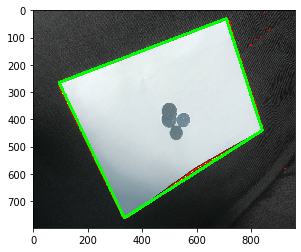

In [6]:
cnt=contour[index]

cv2.drawContours(img, [cnt], 0, (255, 255, 0), 1)

epsilon1 = 0.1*cv2.arcLength(cnt, True)
approx1 = cv2.approxPolyDP(cnt, epsilon1, True)

cv2.drawContours(img, [approx1], 0, (0, 255, 0), 10)

plt.imshow(img)

In [7]:
print(approx1)

[[[708  31]]

 [[ 95 265]]

 [[334 761]]

 [[840 440]]]


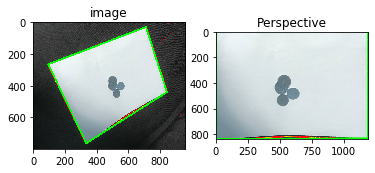

True

In [9]:
# Perspective Transform
    
pts0 = np.float32([approx1[1], approx1[2], approx1[0], approx1[3]])

# (1) A4용지의 size로 맞추기
# cv2.getPerspectiveTransform(src, dst) -> retval
# cv2.warpPerspective(src, M, dsize[, dst[, flags[, borderMode[, borderValue]]]]) -> dst

pts2 = np.float32([[0,0], [0,841], [1189,0], [1189,841]])
M = cv2.getPerspectiveTransform(pts0, pts2)
dst = cv2.warpPerspective(img, M, (1189,841))

'''
# (2) A5용지의 size로 맞추기
pts2 = np.float32([[0,0],[0,437],[640,0],[640,437]])
M = cv2.getPerspectiveTransform(pts0, pts2)
dst = cv2.warpPerspective(img, M, (640,437))
'''



plt.subplot(121),plt.imshow(img),plt.title('image')
plt.subplot(122),plt.imshow(dst),plt.title('Perspective')
plt.show()

cv2.imshow('img',dst)
cv2.waitKey(0)
cv2.destroyAllWindows()


# 이미지 저장하기
cv2.imwrite('done.jpg', dst)

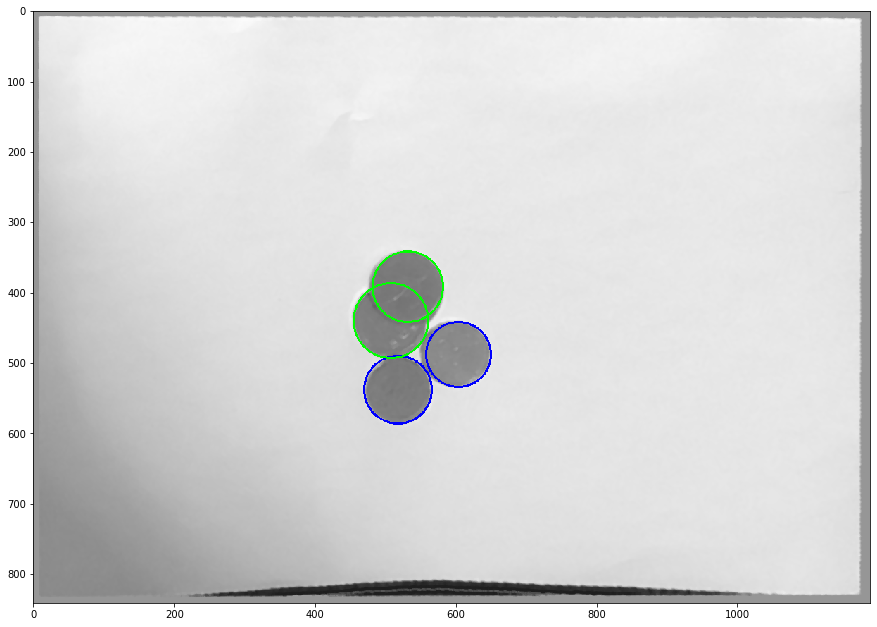

In [10]:
# 1) 동전 검출

overlap = cv2.imread('done.jpg', 0)              # 위에서까지 실행한 이미지를 'done.jpg'라고 저장하고, overlap에 불러옴
overlap = cv2.medianBlur(overlap, 5)             # Blur 처리해서 noise를 제거
cimg = cv2.cvtColor(overlap, cv2.COLOR_GRAY2BGR)

# 겹친 동전의 모양까지 원으로 검출하는 기준을 정의한다
# cv2.HoughCircles(image, method, dp, minDist[, circles[, param1[, param2[, minRadius[, maxRadius]]]]]) -> circles
circles = cv2.HoughCircles(overlap, cv2.HOUGH_GRADIENT, 1, 20, np.array([]), param1=150, param2=20, minRadius=15, maxRadius=55)
circles = np.uint16(np.around(circles))

fivehund = 0
onehund = 0
fifty = 0
ten = 0

# 위 조건에 맞춰 cimg에 원을 그린다
for circ in circles[0,:]:
    if circ[2] >= 50: #or circ[2] >= 38 or circ[2] >= 28:
        fivehund += 1
        cv2.circle(cimg, (circ[0], circ[1]), circ[2], (0,255,0) ,2)
    elif circ[2] >= 44: #or circ[2] >= 35 or circ[2] >= 25:
        onehund += 1
        cv2.circle(cimg, (circ[0], circ[1]), circ[2], (0,0,255) ,2)
    elif circ[2] >= 30: #or circ[2] >= 22:
        fifty += 1
        cv2.circle(cimg, (circ[0], circ[1]), circ[2], (0,0,0) ,2)
    else:
        ten += 1
        cv2.circle(cimg, (circ[0], circ[1]), circ[2], (255,0,0), 2)


        
        
# 원형의 컨투어가 따인 cimg 출력
cv2.imshow('img', cimg)
cv2.waitKey(0)
cv2.destroyAllWindows()

plt.figure(figsize=(15,15))
plt.imshow(cimg)
plt.show()

In [11]:
# 동전 좌표 확인

count = circles[0,:]        # 인식된 원의 개수를 count라고 지정한다
# len(count)                  # 인식된 원의 개수를 세어서 반환한다
c_array = circles.reshape(len(count), -1)                      # 검출된 원의 개수를 행의 개수로 하는 배열을 array라고 지정한다
radiusSet = c_array[:,-1]

print('\n(x좌표, y좌표, 반지름) 배열: \n', c_array)     # 여기서 x,y좌표는 원의 중심의 좌표를 의미함
print('\n동전의 반지름 리스트: \n', radiusSet)


(x좌표, y좌표, 반지름) 배열: 
 [[604 488  46]
 [518 538  48]
 [508 440  53]
 [532 392  50]]

동전의 반지름 리스트: 
 [46 48 53 50]


In [12]:
# 총액 계산

total = (500 * fivehund + 100 * onehund + 50 * fifty + 10 * ten)

print('500원: {} 개'.format(fivehund),
      '\n100원: {} 개'.format(onehund),
      '\n 50원: {} 개'.format(fifty),
      '\n 10원: {} 개'.format(ten))
print('동전 총합: {} 원'.format(total))

500원: 2 개 
100원: 2 개 
 50원: 0 개 
 10원: 0 개
동전 총합: 1200 원


In [26]:
# 토탈 결과값 환전

import requests
import json

headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'}

def jpy2krw():
    url = 'https://quotation-api-cdn.dunamu.com/v1/forex/recent?codes=FRX.KRWJPY'
    exchange = requests.get(url, headers=headers).json()
    return exchange[0]['basePrice']

def usd2krw():
    url = 'https://quotation-api-cdn.dunamu.com/v1/forex/recent?codes=FRX.KRWUSD'
    exchange = requests.get(url, headers=headers).json()
    return exchange[0]['basePrice']


# 외화 1 단위 --> 원화
usd = usd2krw()
jpy = jpy2krw()

print('환율 : 1 달러 당', usd)
print('환율 : 1 엔 당', jpy / 100)


# 원화 --> 외화
usd_tot = total / usd
jpy_tot = total / (jpy/100)

usd_tot = round(usd_tot, 2)
jpy_tot = round(jpy_tot, 2)

print('\n총액은 달러로', usd_tot)
print('총액은 엔으로', jpy_tot)

환율 : 1 달러 당 1159.5
환율 : 1 엔 당 10.7049

총액은 달러로 1.03
총액은 엔으로 112.1
